# "Explainable Automated Hate Speech Detection and the Problem of Offensive Language"

In [2]:
!pip install --upgrade vaderSentiment

In [367]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import make_pipeline

from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import RandomForestClassifier
from collections import OrderedDict

## Loading the data

In [4]:
df = pd.read_csv("../data/labeled_data.csv")

In [274]:
df.values[0:10]

array([[0, 3, 0, 0, 3, 2,
        "!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."],
       [1, 3, 0, 3, 0, 1,
        '!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!'],
       [2, 3, 0, 3, 0, 1,
        '!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit'],
       [3, 3, 0, 2, 1, 1,
        '!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny'],
       [4, 6, 0, 6, 0, 1,
        '!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;'],
       [5, 3, 1, 2, 0, 1,
        '!!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just blows me..claim you so faithful and down for somebody but still fucking with hoes! &#128514;&#128514;&#128514;"'],
       [6, 3, 0, 3, 0, 1,
        '!!!!!!"@__BrighterDays: I can

In [6]:
df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [7]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text


<AxesSubplot:>

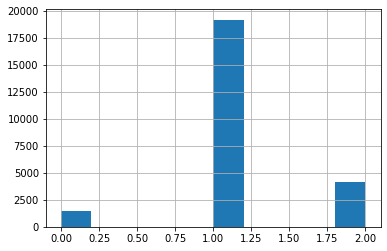

In [8]:
df['class'].hist()

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

In [9]:
tweets=df.tweet

## Feature generation

In [335]:
stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=True,
    preprocessor=preprocess,
    #ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    #decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75,
    )

In [336]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [337]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}

In [279]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mosta\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [247]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [320]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    #ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    #decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75,
    )

In [321]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [282]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [290]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [291]:
feats = get_feature_array(tweets)

In [338]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [339]:
M.shape

(24783, 4885)

In [340]:
print(vocab)

{'00': 0, '000': 1, '0221': 2, '10': 3, '100': 4, '1000': 5, '10071': 6, '10084': 7, '1041185': 8, '1041191': 9, '1041196': 10, '1041204': 11, '1041219': 12, '1041240': 13, '1043215': 14, '1043291': 15, '1043323': 16, '1043351': 17, '1043358': 18, '1043359': 19, '11': 20, '12': 21, '127797': 22, '127811': 23, '127814': 24, '127825': 25, '127867': 26, '127881': 27, '127908': 28, '127911': 29, '127926': 30, '127936': 31, '127942': 32, '128049': 33, '128056': 34, '128064': 35, '128068': 36, '128069': 37, '128070': 38, '128072': 39, '128073': 40, '128074': 41, '128075': 42, '128076': 43, '128077': 44, '128078': 45, '128079': 46, '128080': 47, '128081': 48, '128107': 49, '128109': 50, '128111': 51, '128120': 52, '128123': 53, '128128': 54, '128129': 55, '128130': 56, '128131': 57, '128133': 58, '128134': 59, '128138': 60, '128139': 61, '128141': 62, '128142': 63, '128143': 64, '128145': 65, '128148': 66, '128149': 67, '128152': 68, '128153': 69, '128155': 70, '128158': 71, '128162': 72, '12

In [341]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names
print(feature_names)

['00', '000', '0221', '10', '100', '1000', '10071', '10084', '1041185', '1041191', '1041196', '1041204', '1041219', '1041240', '1043215', '1043291', '1043323', '1043351', '1043358', '1043359', '11', '12', '127797', '127811', '127814', '127825', '127867', '127881', '127908', '127911', '127926', '127936', '127942', '128049', '128056', '128064', '128068', '128069', '128070', '128072', '128073', '128074', '128075', '128076', '128077', '128078', '128079', '128080', '128081', '128107', '128109', '128111', '128120', '128123', '128128', '128129', '128130', '128131', '128133', '128134', '128138', '128139', '128141', '128142', '128143', '128145', '128148', '128149', '128152', '128153', '128155', '128158', '128162', '128165', '128166', '128168', '128169', '128170', '128175', '128176', '128181', '128184', '128221', '128293', '128298', '128299', '128513', '128514', '128515', '128516', '128517', '128518', '128520', '128521', '128522', '128523', '128524', '128525', '128526', '128527', '128528', '1285

# Running the model

The best model was selected using a GridSearch with 5-fold CV.

In [342]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [326]:
from sklearn.model_selection import train_test_split

In [343]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [328]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [354]:
model = LogisticRegression(class_weight='balanced', solver = "liblinear")
model = model.fit(X_train, y_train)


In [355]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [356]:
from sklearn.metrics import f1_score
train_cv = f1_score(y_train, train_pred, average = "macro")
print(train_cv)
val_cv = f1_score(y_test, test_pred, average = "macro")
print(val_cv)

0.8593882464595564
0.7297042476774696


## Evaluating the results

In [357]:
train_report = classification_report( y_train, train_pred)
print(train_report)

              precision    recall  f1-score   support

           0       0.62      0.78      0.69      1266
           1       0.98      0.94      0.96     17285
           2       0.88      0.98      0.93      3753

    accuracy                           0.94     22304
   macro avg       0.83      0.90      0.86     22304
weighted avg       0.94      0.94      0.94     22304



In [358]:
report = classification_report( y_test, test_pred)
print(report)

              precision    recall  f1-score   support

           0       0.38      0.43      0.40       164
           1       0.95      0.91      0.93      1905
           2       0.81      0.91      0.86       410

    accuracy                           0.88      2479
   macro avg       0.71      0.75      0.73      2479
weighted avg       0.89      0.88      0.88      2479



***Note: Results in paper are from best model retrained on the entire dataset (see the other notebook). Here the results are reported after using cross-validation and only for the held-out set.***

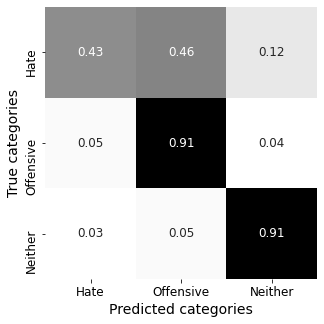

In [359]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,test_pred)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

<AxesSubplot:>

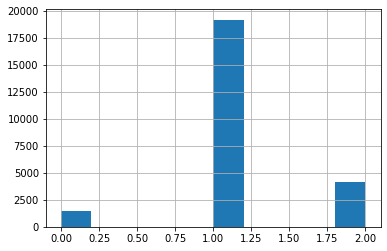

In [307]:
#True distribution
y.hist()

<AxesSubplot:>

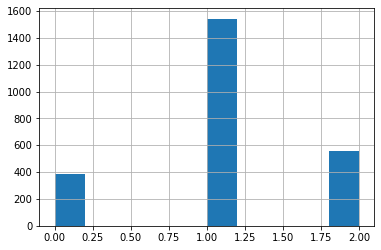

In [308]:
pd.Series(y_preds).hist()

In [360]:
idx = 101
num_features = 30
c =  make_pipeline(model)
print(model.predict(X_test.iloc[idx].values.reshape(1,-1)))
print(c.predict_proba(X_test.iloc[idx].values.reshape(1,-1)))
class_names = ['Hate','Offensive','Neither']
explainer = LimeTabularExplainer(X_train.values[:,:],feature_names=feature_names, verbose=True)


[1]
[[1.63999958e-04 9.83126859e-01 1.67091413e-02]]


In [361]:
exp = explainer.explain_instance(X_train.values[idx,:], c.predict_proba, num_features = num_features, top_labels=3)

Intercept 0.46597071726070505
Prediction_local [0.18906295]
Right: 0.00606180430241252
Intercept 0.9477192276835265
Prediction_local [0.17516601]
Right: 0.12120330594323145
Intercept -0.1247352586753917
Prediction_local [0.63575106]
Right: 0.872734889754356


In [362]:
exp.show_in_notebook()

In [363]:
print ('Explanation for class %s' % class_names[0])
print ('\n'.join(map(str, exp.as_list(0))))

Explanation for class Hate
('curse <= 0.00', -0.3697291569793382)
('RIP <= 0.00', -0.3652008434007582)
('Before <= 0.00', -0.3413847557460111)
('third <= 0.00', -0.3016692357677075)
('offense <= 0.00', -0.27201860724084487)
('bully <= 0.00', 0.22278415876006077)
('Unlike <= 0.00', -0.2147152089382568)
('series <= 0.00', -0.1998202125011902)
('doors <= 0.00', -0.167400655270805)
('cash <= 0.00', 0.11610137962298504)
('OMG <= 0.00', 0.11594676640748772)
('wing <= 0.00', -0.0899669071841446)
('Gettin <= 0.00', 0.08710233690784185)
('liking <= 0.00', 0.08700556047137276)
('reasons <= 0.00', 0.0869758373552739)
('fully <= 0.00', 0.08608955104419372)
('heartless <= 0.00', 0.08607694177905147)
('signed <= 0.00', 0.08593868030593507)
('Bunch <= 0.00', 0.08590598946462452)
('silver <= 0.00', 0.08416968739772401)
('opened <= 0.00', 0.07690890992549587)
('mental <= 0.00', 0.07575353766472898)
('evolved <= 0.00', 0.07520206519655735)
('Daily <= 0.00', 0.07456194232278648)
('Mets <= 0.00', -0.06066

In [364]:
print ('Explanation for class %s' % class_names[1])
print ('\n'.join(map(str, exp.as_list(1))))

Explanation for class Offensive
('fair <= 0.00', 0.3570609160498894)
('purse <= 0.00', 0.2909008623838239)
('RIP <= 0.00', 0.27219486185057157)
('ig <= 0.00', 0.2674480627440718)
('Favorite <= 0.00', 0.2648959455596924)
('fully <= 0.00', -0.25033691339017533)
('keys <= 0.00', 0.20397265719529822)
('series <= 0.00', 0.19623957064295064)
('threat <= 0.00', -0.17734743057638178)
('def <= 0.00', 0.17679618418547316)
('kissed <= 0.00', -0.1715162614505273)
('bully <= 0.00', -0.17010102136189947)
('Monkey <= 0.00', -0.16196019176375276)
('breaking <= 0.00', -0.15741948493680405)
('Gonna <= 0.00', 0.15066403718989968)
('128686 <= 0.00', -0.12443138908166076)
('liking <= 0.00', -0.12013737712950828)
('relationships <= 0.00', -0.11431035847094843)
('passed <= 0.00', 0.11317025523828404)
('FAKE <= 0.00', -0.09825970802746593)
('Ben <= 0.00', -0.08375354485952907)
('proof <= 0.00', 0.08089221574224753)
('weeknd <= 0.00', -0.07984285172483259)
('rookie <= 0.00', 0.07282236673819548)
('Scandal <= 0

In [365]:
print ('Explanation for class %s' % class_names[2])
print ('\n'.join(map(str, exp.as_list(2))))

Explanation for class Neither
('fair <= 0.00', -0.3773936670797996)
('ladykimora <= 0.00', -0.2788513234507075)
('evolved <= 0.00', -0.2571293998640346)
('ig <= 0.00', -0.2530119892092017)
('Glizzy <= 0.00', -0.24787663729505785)
('pulled <= 0.00', -0.21972288612263474)
('passed <= 0.00', -0.17078358700726096)
('company <= 0.00', 0.15147574440896577)
('nigglet <= 0.00', 0.12567402621771584)
('fame <= 0.00', -0.11488410005760308)
('gain <= 0.00', 0.11067971403873192)
('cakes <= 0.00', 0.09420465386455523)
('DJ <= 0.00', 0.09417048236003428)
('purge <= 0.00', 0.09361122285522827)
('Scandal <= 0.00', 0.09334184081169553)
('threat <= 0.00', 0.09111291614952081)
('kissed <= 0.00', 0.09031508415534957)
('yasss <= 0.00', 0.0886051061328014)
('Last <= 0.00', 0.08567315457058841)
('Monkey <= 0.00', 0.07508436872537254)
('breaking <= 0.00', 0.07491756330278494)
('ruin <= 0.00', 0.07413814618565037)
('bound <= 0.00', 0.0711297622228219)
('twerkin <= 0.00', 0.06800777529242996)
('father <= 0.00', 

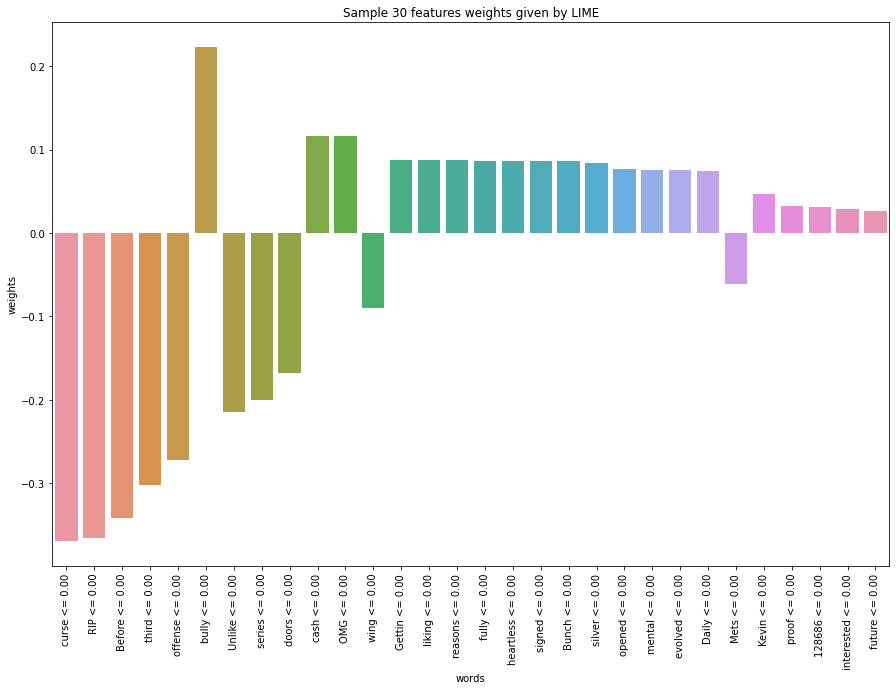

In [368]:
weights = OrderedDict(exp.as_list(0))
lime_weights = pd.DataFrame({"words": list(weights.keys()), "weights": list(weights.values())})

plt.figure(figsize=(15,10))
sns.barplot(x = "words", y = "weights", data = lime_weights)
plt.xticks(rotation = 90)
plt.title("Sample {} features weights given by LIME".format(num_features))
plt.show()

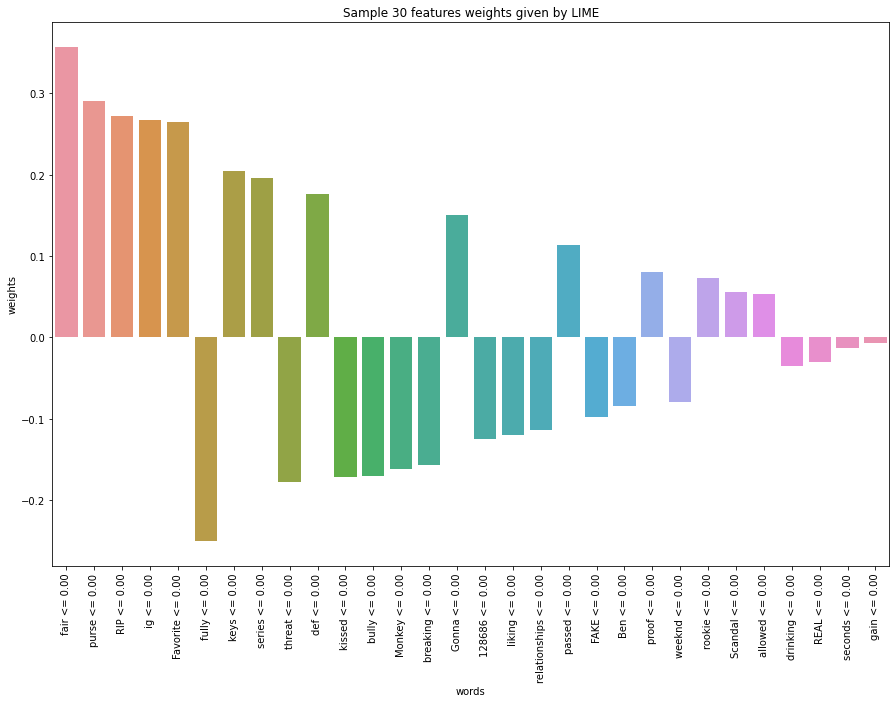

In [369]:
weights = OrderedDict(exp.as_list(1))
lime_weights = pd.DataFrame({"words": list(weights.keys()), "weights": list(weights.values())})

plt.figure(figsize=(15,10))
sns.barplot(x = "words", y = "weights", data = lime_weights)
plt.xticks(rotation = 90)
plt.title("Sample {} features weights given by LIME".format(num_features))
plt.show()

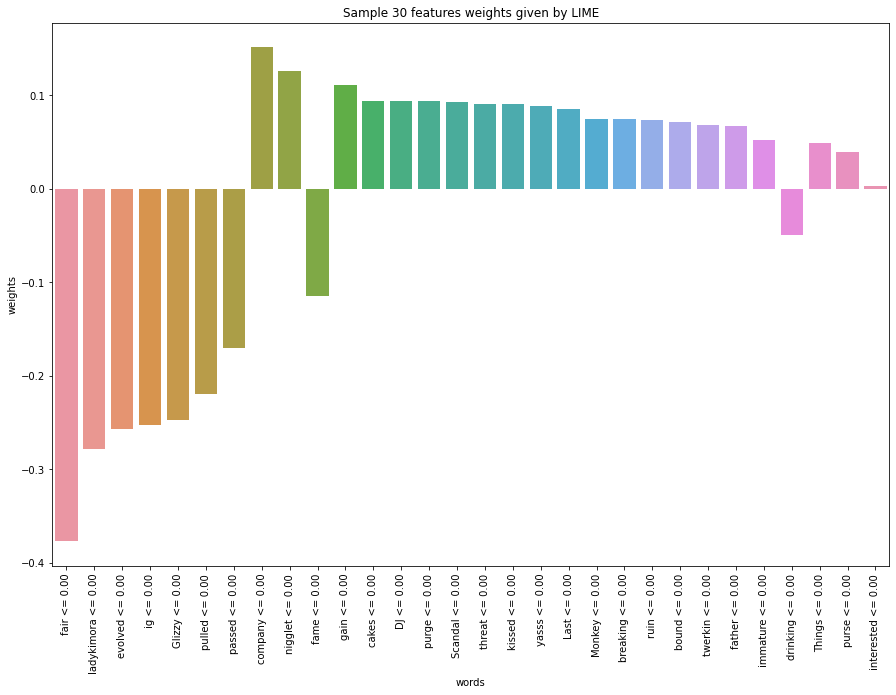

In [370]:
weights = OrderedDict(exp.as_list(2))
lime_weights = pd.DataFrame({"words": list(weights.keys()), "weights": list(weights.values())})

plt.figure(figsize=(15,10))
sns.barplot(x = "words", y = "weights", data = lime_weights)
plt.xticks(rotation = 90)
plt.title("Sample {} features weights given by LIME".format(num_features))
plt.show()